<a href="https://colab.research.google.com/github/ChowchowWorks/Weather-Prediction/blob/main/Weather_Pred_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Section 1: CSV Handling**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
!pip install optuna
import optuna
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('weather_data.csv')

#**Section 2: Helper Functions**

In [ ]:
# removes outliers from humidity column only
def removeOutliers(dataframe):
  dataframe = dataframe[dataframe['relative_humidity'] <= 1]
  return dataframe

# splits the data into X values and Y values (returns arrays)
def splitDataIntoArray(data):
  if isinstance(data, pd.DataFrame):
    data = data.to_numpy()
  X = data[:, :-1]
  y = data[:, -1]
  return X, y

# creating windows for prediction
def create_windows(data, n_steps, forecast_steps):
    X, y = [], []
    for i in range(n_steps, len(data) - forecast_steps):
        X.append(data[i - n_steps:i, :-1])  # Use N previous time points as features
        y.append(data[i + forecast_steps - 1, -1])  # Predict target after forecast_steps
    return np.array(X), np.array(y)

# this is the standardisation scaler
scaler = StandardScaler()

# **Section 3: Unsupervised Learning**

(a) correlation matrix for full data

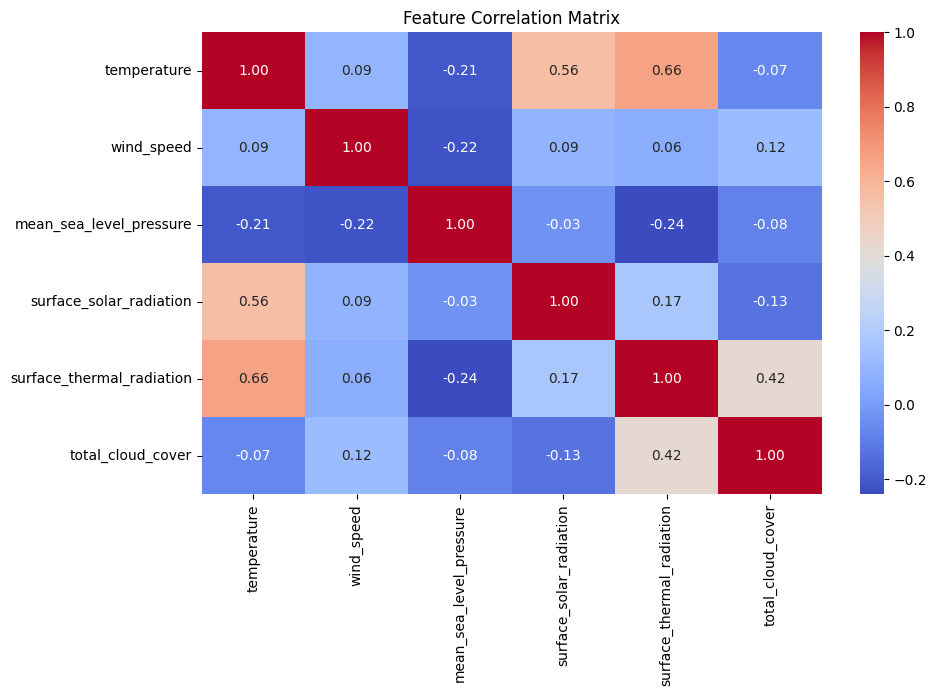

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using full dataset
Full_Train = df.iloc[:, :6]
Full_Test = df.iloc[:, -1]

# Compute correlation matrix
corr_matrix = Full_Train.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

(b) ACF and PACF

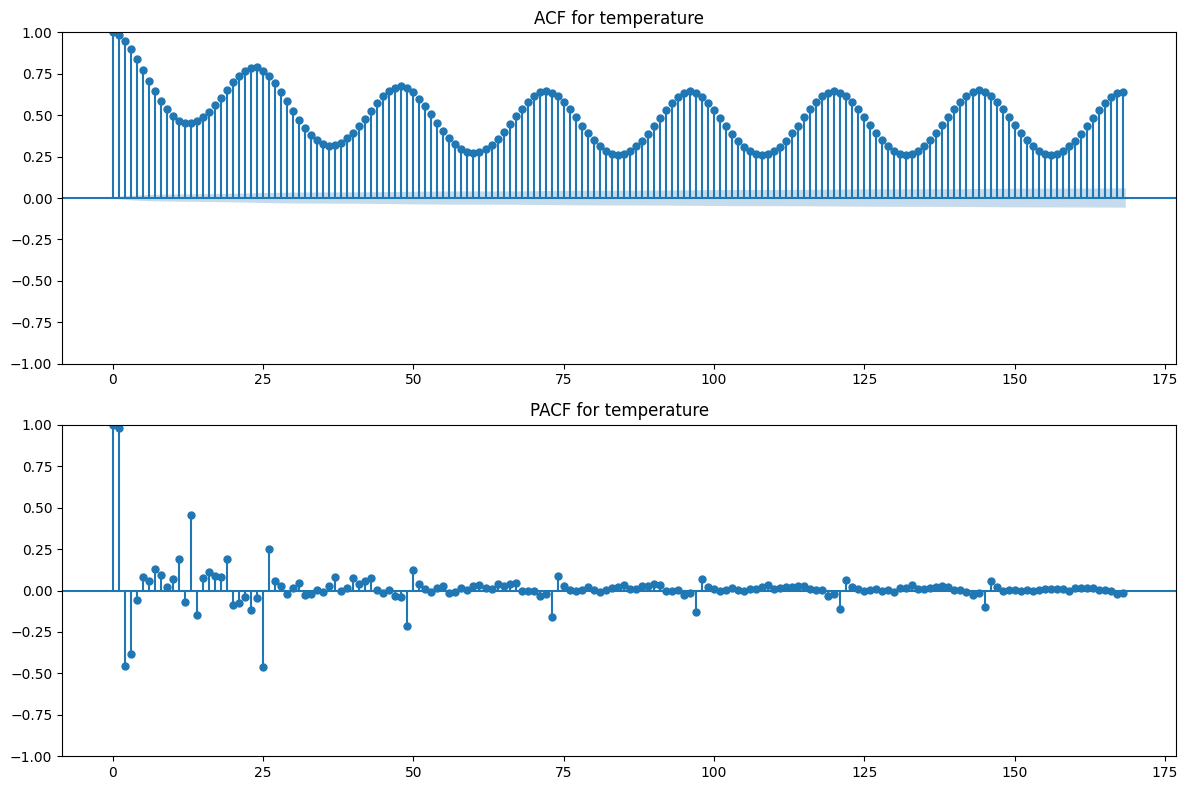


Feature: temperature
Top ACF lags (percentile): [1, 2, 3, 4, 5, 22, 23, 24, 25]
Top ACF lags (absolute threshold): [1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 68, 69, 70, 71, 72, 73, 74, 75, 76, 92, 93, 94, 95, 96, 97, 98, 99, 100, 116, 117, 118, 119, 120, 121, 122, 123, 124, 140, 141, 142, 143, 144, 145, 146, 147, 148, 164, 165, 166, 167, 168]
Top PACF lags (percentile): [1, 2, 3, 11, 13, 19, 25, 26, 49]
Top PACF lags (absolute threshold): [1, 2, 3, 13, 25]


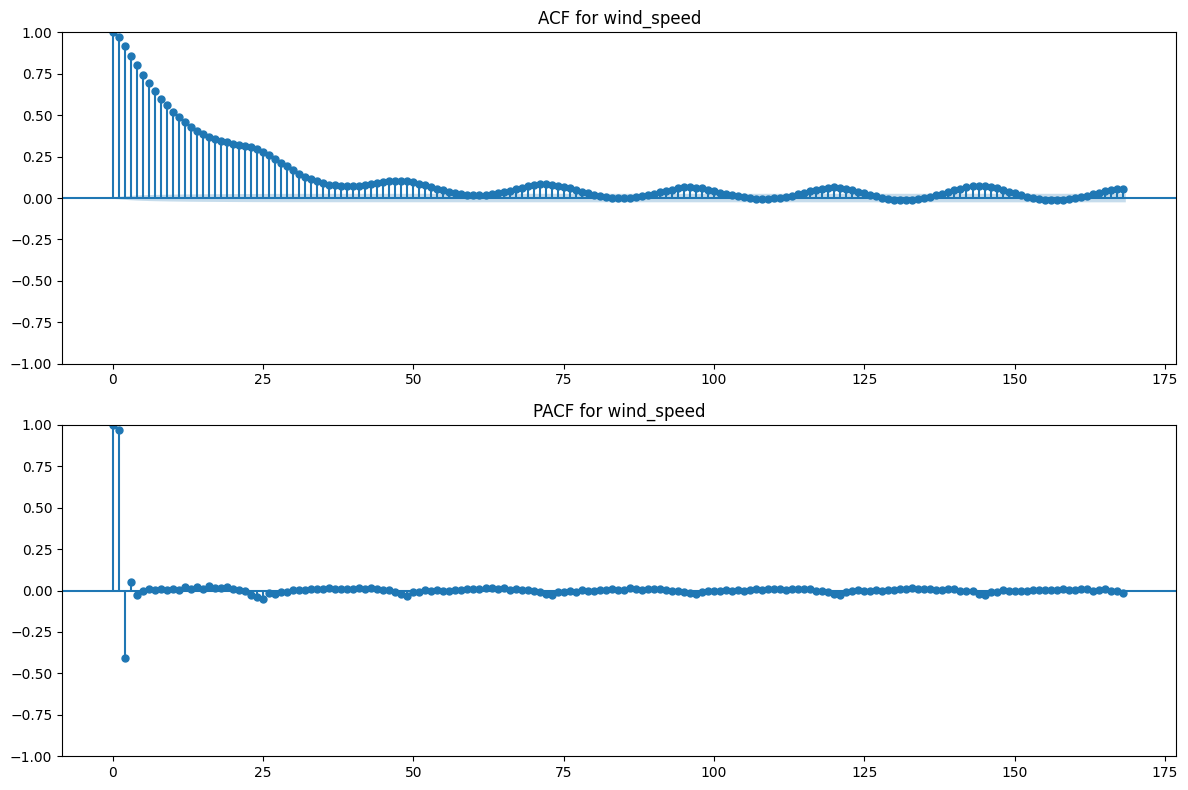


Feature: wind_speed
Top ACF lags (percentile): [1, 2, 3, 4, 5, 6, 7, 8, 9]
Top ACF lags (absolute threshold): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Top PACF lags (percentile): [1, 2, 3, 4, 24, 25, 49, 121, 145]
Top PACF lags (absolute threshold): [1, 2]


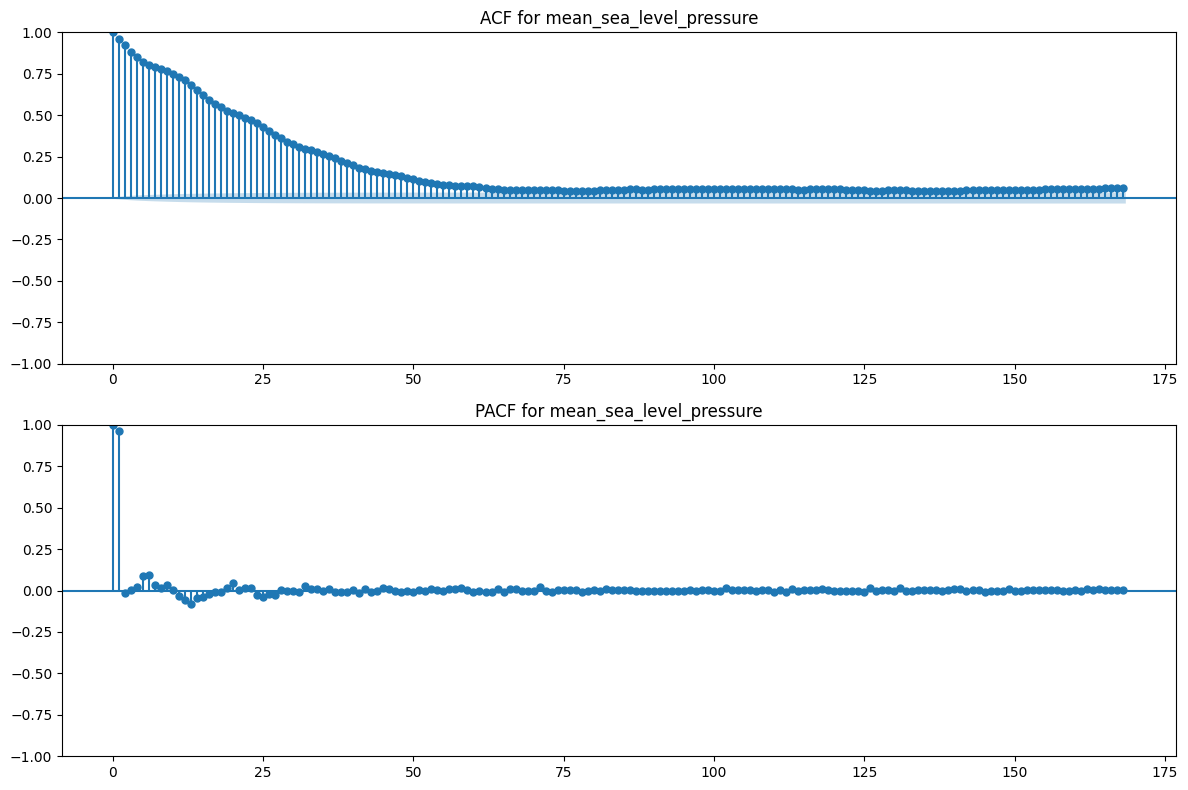


Feature: mean_sea_level_pressure
Top ACF lags (percentile): [1, 2, 3, 4, 5, 6, 7, 8, 9]
Top ACF lags (absolute threshold): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Top PACF lags (percentile): [1, 5, 6, 12, 13, 14, 15, 20, 25]
Top PACF lags (absolute threshold): [1]


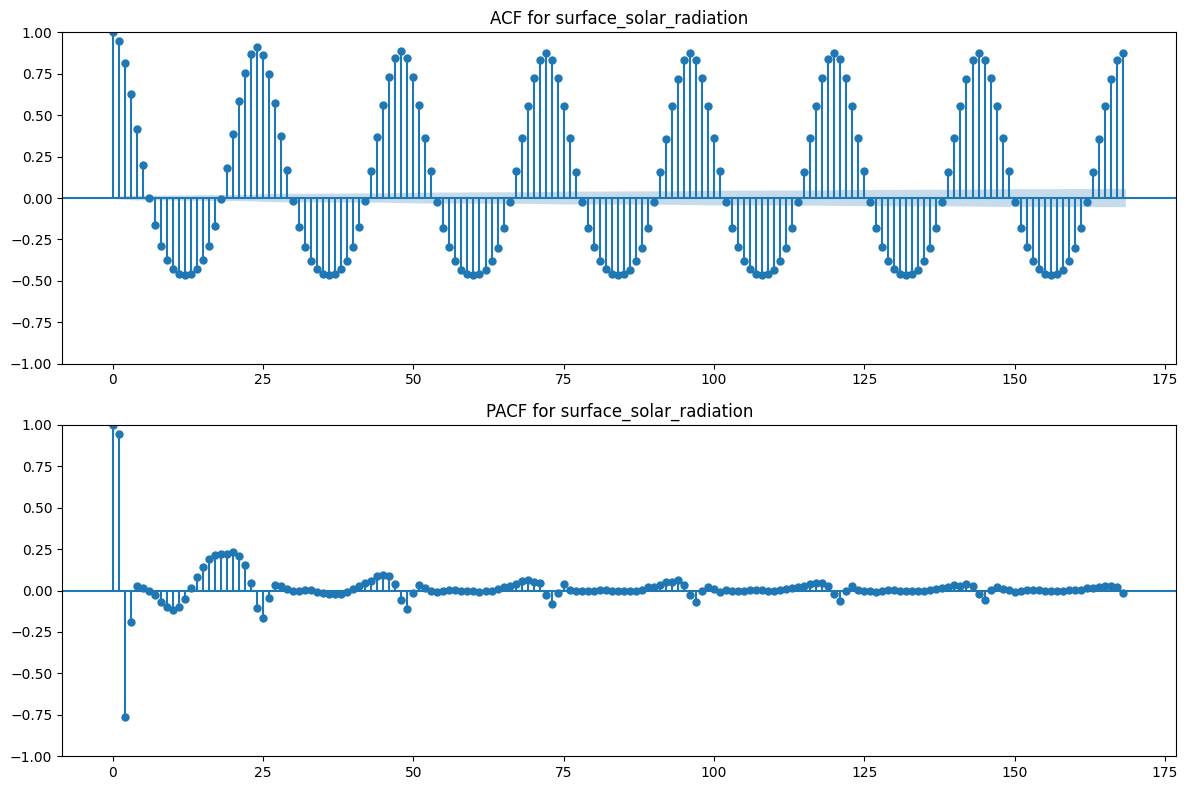


Feature: surface_solar_radiation
Top ACF lags (percentile): [1, 23, 24, 48, 72, 96, 120, 144, 168]
Top ACF lags (absolute threshold): [1, 2, 3, 21, 22, 23, 24, 25, 26, 27, 45, 46, 47, 48, 49, 50, 51, 69, 70, 71, 72, 73, 74, 75, 93, 94, 95, 96, 97, 98, 99, 117, 118, 119, 120, 121, 122, 123, 141, 142, 143, 144, 145, 146, 147, 165, 166, 167, 168]
Top PACF lags (percentile): [1, 2, 3, 16, 17, 18, 19, 20, 21]
Top PACF lags (absolute threshold): [1, 2]


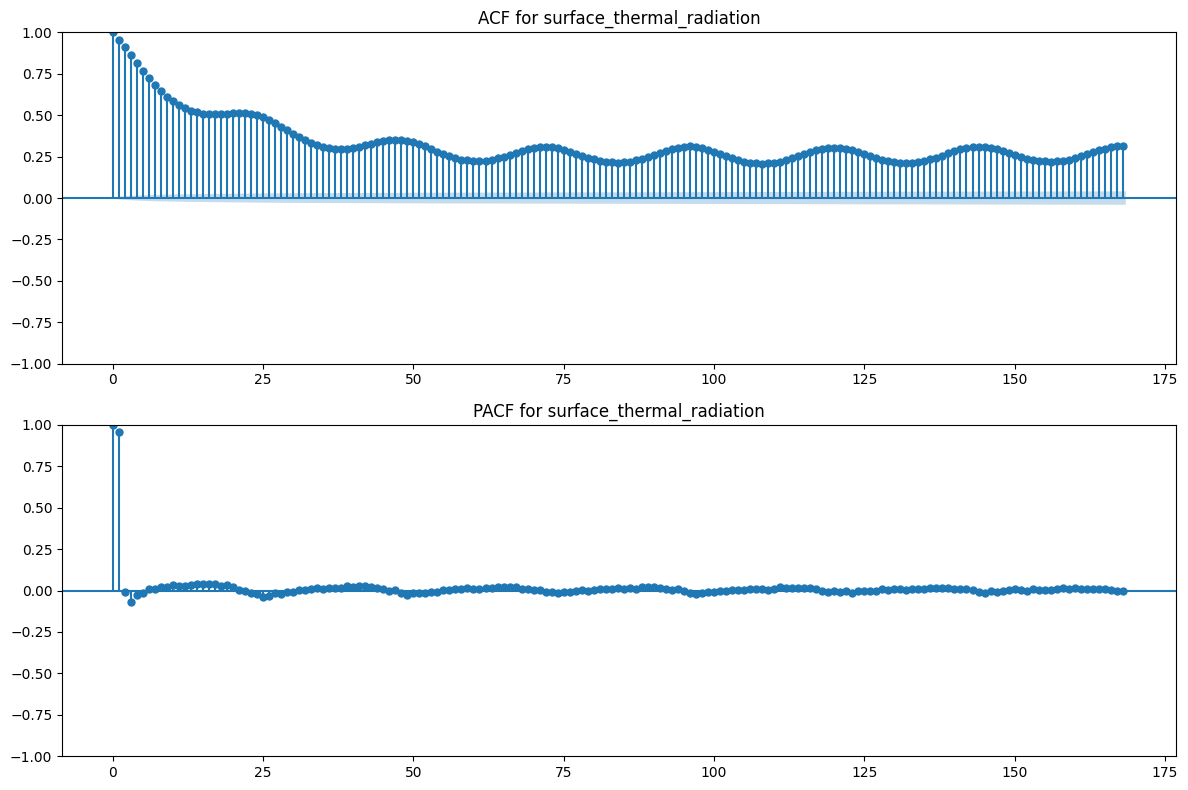


Feature: surface_thermal_radiation
Top ACF lags (percentile): [1, 2, 3, 4, 5, 6, 7, 8, 9]
Top ACF lags (absolute threshold): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Top PACF lags (percentile): [1, 3, 13, 14, 15, 16, 17, 25, 26]
Top PACF lags (absolute threshold): [1]


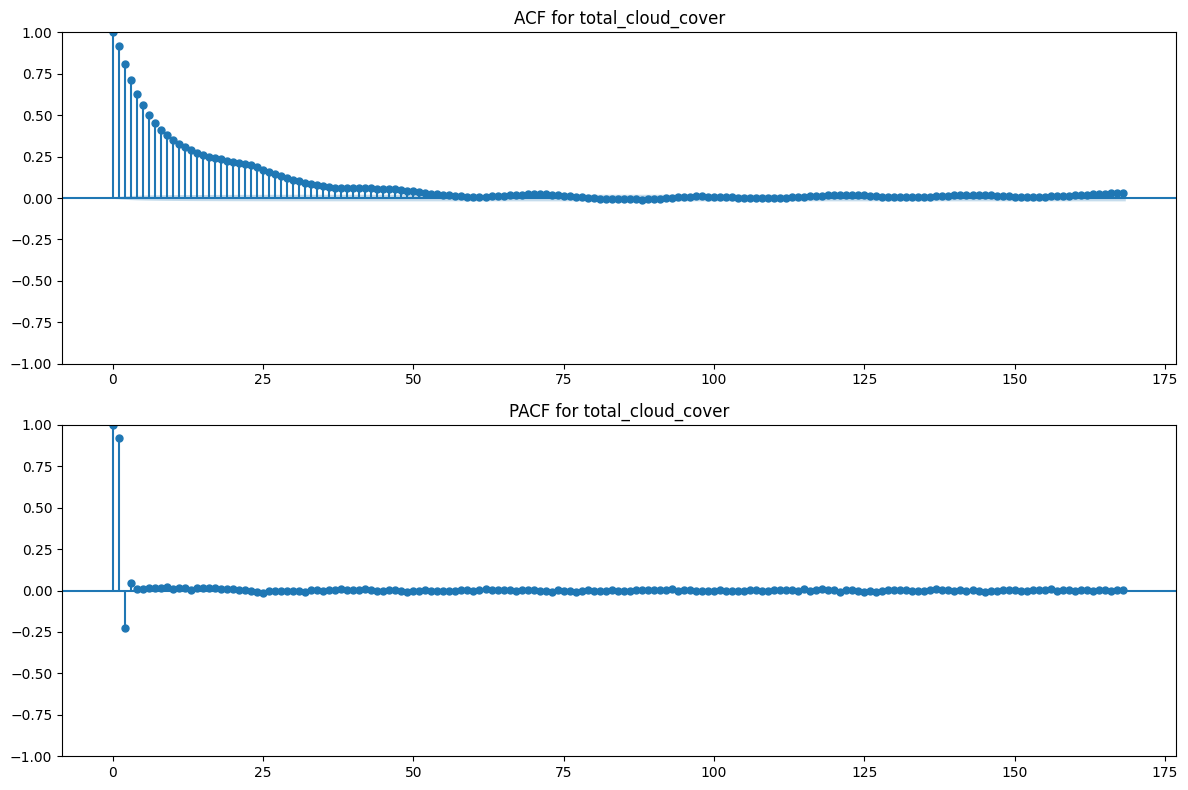


Feature: total_cloud_cover
Top ACF lags (percentile): [1, 2, 3, 4, 5, 6, 7, 8, 9]
Top ACF lags (absolute threshold): [1, 2, 3, 4, 5, 6]
Top PACF lags (percentile): [1, 2, 3, 6, 8, 9, 11, 15, 25]
Top PACF lags (absolute threshold): [1]


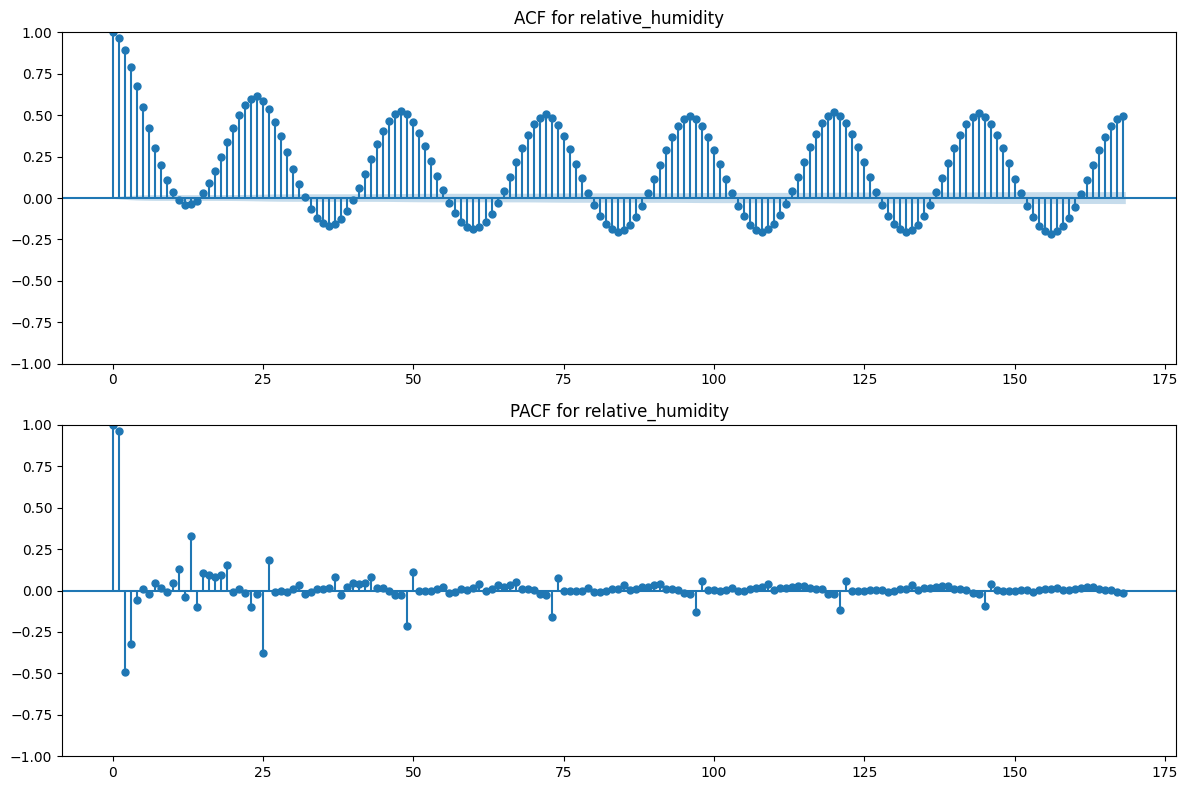


Feature: relative_humidity
Top ACF lags (percentile): [1, 2, 3, 4, 5, 22, 23, 24, 25]
Top ACF lags (absolute threshold): [1, 2, 3, 4, 5, 21, 22, 23, 24, 25, 26, 47, 48, 49, 72, 120, 144]
Top PACF lags (percentile): [1, 2, 3, 13, 19, 25, 26, 49, 73]
Top PACF lags (absolute threshold): [1, 2, 3, 13, 25]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

def analyze_all_features(df, max_lag=168):
    numeric_features = df.select_dtypes(include=[np.number]).columns

    for feature in numeric_features:
        plt.figure(figsize=(12, 8))

        plt.subplot(211)
        plot_acf(df[feature].dropna(), lags=max_lag, ax=plt.gca(),
                 title=f'ACF for {feature}')

        plt.subplot(212)
        plot_pacf(df[feature].dropna(), lags=max_lag, ax=plt.gca(),
                  title=f'PACF for {feature}')

        plt.tight_layout()
        plt.show()

        # Optional: print significant lags
        acf_vals, confint_acf = acf(df[feature].dropna(), nlags=max_lag, alpha=0.05) #added confidence intervals
        pacf_vals, confint_pacf = pacf(df[feature].dropna(), nlags=max_lag, alpha=0.05)  #added confidence intervals

        n = len(df)
        acf_percentile_threshold = np.percentile(np.abs(acf_vals[1:]), 95)  # Only top 5% strongest
        pacf_percentile_threshold = np.percentile(np.abs(pacf_vals[1:]), 95)

        absolute_threshold_acf = 0.5  # Only correlations stronger than 0.5
        absolute_threshold_pacf = 0.3

        sig_acf_percentile = [i for i, val in enumerate(acf_vals) if abs(val) > acf_percentile_threshold and i > 0]
        sig_pacf_percentile = [i for i, val in enumerate(pacf_vals) if abs(val) > pacf_percentile_threshold and i > 0]
        acf_absolute = [i for i, val in enumerate(acf_vals) if abs(val) > absolute_threshold_acf and i > 0]
        pacf_absolute = [i for i, val in enumerate(pacf_vals) if abs(val) > absolute_threshold_pacf and i > 0]

        print(f"\nFeature: {feature}")
        print(f"Top ACF lags (percentile): {sig_acf_percentile}")
        print(f"Top ACF lags (absolute threshold): {acf_absolute}")
        print(f"Top PACF lags (percentile): {sig_pacf_percentile}")
        print(f"Top PACF lags (absolute threshold): {pacf_absolute}")

analyze_all_features(df, max_lag=168)

(c) ADF and KPSS test

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

numeric_features = df.select_dtypes(include=[np.number]).columns

for feature in numeric_features:
    result = adfuller(df[feature])
    print(f"ADF Statistic for {feature}: {result[0]}")
    print(f"p-value for {feature}: {result[1]}")

numeric_features = df.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    result = kpss(df[feature], regression='c')
    print(f"KPSS Statistic for {feature}: {result[0]}")
    print(f"p-value for {feature}: {result[1]}")

ADF Statistic for temperature: -13.29764812908158
p-value for temperature: 7.152232838567623e-25
ADF Statistic for wind_speed: -28.95821197714215
p-value for wind_speed: 0.0
ADF Statistic for mean_sea_level_pressure: -28.872760286711188
p-value for mean_sea_level_pressure: 0.0
ADF Statistic for surface_solar_radiation: -13.100616205818831
p-value for surface_solar_radiation: 1.712962369181054e-24
ADF Statistic for surface_thermal_radiation: -20.401482267703678
p-value for surface_thermal_radiation: 0.0
ADF Statistic for total_cloud_cover: -43.6816132144692
p-value for total_cloud_cover: 0.0
ADF Statistic for relative_humidity: -20.414138876564078
p-value for relative_humidity: 0.0
KPSS Statistic for temperature: 0.1258322908245214
p-value for temperature: 0.1
KPSS Statistic for wind_speed: 0.3305258883442484
p-value for wind_speed: 0.1
KPSS Statistic for mean_sea_level_pressure: 0.10817035093453425
p-value for mean_sea_level_pressure: 0.1
KPSS Statistic for surface_solar_radiation: 0.0

<ipython-input-9-d1b4575e22fc>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df[feature], regression='c')
<ipython-input-9-d1b4575e22fc>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df[feature], regression='c')
<ipython-input-9-d1b4575e22fc>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df[feature], regression='c')
<ipython-input-9-d1b4575e22fc>:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df[feature], regression='c')
<ipython-inp

(d) Rolling Mean and SD

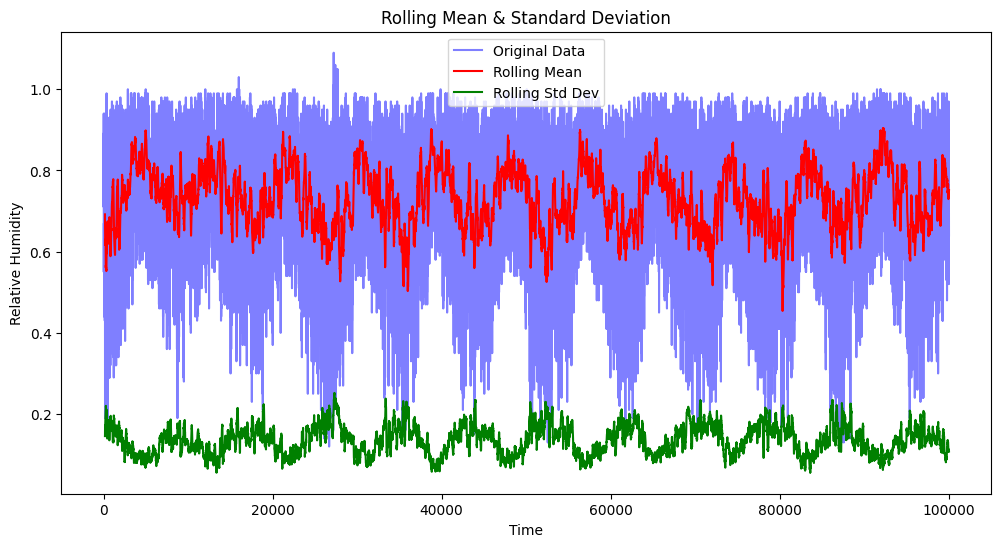

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your dataset and 'relative_humidity' is your target variable
window_size = 24 * 7  # 7-day rolling window (adjust as needed)

# Compute rolling mean and standard deviation
rolling_mean = df['relative_humidity'].rolling(window=window_size).mean()
rolling_std = df['relative_humidity'].rolling(window=window_size).std()

# Plot the original data, rolling mean, and rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(df['relative_humidity'], label='Original Data', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')

plt.xlabel('Time')
plt.ylabel('Relative Humidity')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

# **Section 4: Train-Test Split**

(a) 80-20 Split

In [ ]:
# split data into X values and y values
X, y = splitDataIntoArray(df)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)
print(X_train.shape)

# standardise X_train
X_train = np.array(scaler.fit_transform(X_train))
#X_train = np.hstack((X_train, Day_or_Night[:X_train.shape[0]]))
# standardise X_test
X_test = np.array(scaler.transform(X_test))
#X_test = np.hstack((X_test, Day_or_Night[X_train.shape[0]:]))

# create windows for training data
# N is the number of steps the model will backtrack to predict new data
N = 24

# combine X_train and y_train
y_train = y_train.reshape(y_train.shape[0], 1)
trainingData = np.hstack((X_train, y_train))

# create training data
X_train_1, y_train_1 = create_windows(trainingData, N, 1)
X_train_6, y_train_6 = create_windows(trainingData, N, 6)
X_train_24, y_train_24 = create_windows(trainingData, N, 24)

# create windows for testing data
# combine X_test and y_test
y_test = y_test.reshape(y_test.shape[0], 1)
testingData = np.hstack((X_test, y_test))

X_test_1, y_test_1 = create_windows(testingData, N, 1)
X_test_6, y_test_6 = create_windows(testingData, N, 6)
X_test_24, y_test_24 = create_windows(testingData, N, 24)

(80045, 6)


# **Section 5: Baseline Model - Random Forest**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os

class RandomForestWeatherPredictionModel:
    def __init__(self, data_path, model_path=None):
        self.data_path = data_path
        self.model_path = model_path  # Optional path to a saved model
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

    def load_data(self):
        """Load the data from the CSV file."""
        self.df = pd.read_csv(self.data_path)

    def create_lag_features(self):
        """Generate lag features for the dataset."""
        for lag in range(1, 25):
            self.df[f'temperature_lag_{lag}'] = self.df['temperature'].shift(lag)
            self.df[f'wind_speed_lag_{lag}'] = self.df['wind_speed'].shift(lag)
            self.df[f'mean_sea_level_pressure_lag_{lag}'] = self.df['mean_sea_level_pressure'].shift(lag)
            self.df[f'surface_solar_radiation_lag_{lag}'] = self.df['surface_solar_radiation'].shift(lag)
            self.df[f'surface_thermal_radiation_lag_{lag}'] = self.df['surface_thermal_radiation'].shift(lag)
            self.df[f'total_cloud_cover_lag_{lag}'] = self.df['total_cloud_cover'].shift(lag)
        self.df = self.df.dropna()

    def prepare_features_and_target(self):
        """Prepare feature columns and target variable."""
        feature_cols = [col for col in self.df.columns if 'lag' in col]
        self.X = self.df[feature_cols]
        self.df['target'] = self.df['relative_humidity'].shift(-1)
        self.df.dropna(inplace=True)
        self.X = self.df[feature_cols]
        self.y = self.df['target']

    def scale_features_and_target(self):
        """Scale the features and target variable."""
        self.X = self.scaler_X.fit_transform(self.X)
        self.y = self.scaler_y.fit_transform(self.y.values.reshape(-1, 1))

    def split_data(self):
        """Split the data into training and test sets."""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, shuffle=False)

    def train_model(self):
        """Train the Random Forest model."""
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(self.X_train, self.y_train)

    def load_model(self):
        """Load a pretrained model if path is provided."""
        if self.model_path and os.path.exists(self.model_path):
            self.model = joblib.load(self.model_path)
            print(f"✅ Loaded pretrained model from {self.model_path}")
            return True
        return False

    def evaluate_model(self):
        """Evaluate the model performance."""
        y_pred = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)
        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        return mse, mae

    def run(self):
        """Run the full model pipeline."""
        self.load_data()
        self.create_lag_features()
        self.prepare_features_and_target()
        self.scale_features_and_target()
        self.split_data()

        if not self.load_model():
            self.train_model()
            joblib.dump(self.model, "./rf_1h.joblib")
            print("✅ Model trained and saved as rf_6h.joblib")

        self.evaluate_model()

# **Section 6: Model 2 - XGBoost Model**

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

class XGBWeatherHumidityPredictor:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        self.preprocess_data()
        self.split_data()
        self.model = None

    def preprocess_data(self):
        start_date = "2010-01-01 00:00:00"
        num_hours = len(self.df)
        date_range = pd.date_range(start=start_date, periods=num_hours, freq='H')
        self.df.index = date_range

        self.df['month'] = self.df.index.month
        self.df['weekday'] = self.df.index.weekday
        self.df['season'] = (self.df['month'] % 12 + 3) // 3

        lags = [1, 6, 24]
        for lag in lags:
            for col in ['temperature', 'wind_speed', 'mean_sea_level_pressure',
                        'surface_solar_radiation', 'surface_thermal_radiation', 'total_cloud_cover']:
                self.df[f'{col}_lag_{lag}h'] = self.df[col].shift(lag)

        self.df['temp_x_cloud'] = self.df['temperature'] * self.df['total_cloud_cover']
        self.df['wind_x_solar'] = self.df['wind_speed'] * self.df['surface_solar_radiation']
        self.df['pressure_x_cloud'] = self.df['mean_sea_level_pressure'] * self.df['total_cloud_cover']

        for col in ['temperature', 'wind_speed', 'mean_sea_level_pressure']:
            self.df[f'{col}_diff_1h'] = self.df[col].diff(1)
            self.df[f'{col}_diff_6h'] = self.df[col].diff(6)
        self.df.dropna(inplace=True)

        self.df['humidity_1h'] = self.df['relative_humidity'].shift(-1)
        self.df['humidity_6h'] = self.df['relative_humidity'].shift(-6)
        self.df['humidity_24h'] = self.df['relative_humidity'].shift(-24)
        self.df.dropna(inplace=True)

    def split_data(self):
        self.X = self.df.drop(columns=['relative_humidity', 'humidity_1h', 'humidity_6h', 'humidity_24h'])
        self.Y = self.df[['humidity_1h']]
        train_size = int(0.8 * len(self.df))
        self.X_train, self.X_test = self.X.iloc[:train_size], self.X.iloc[train_size:]
        self.Y_train, self.Y_test = self.Y.iloc[:train_size], self.Y.iloc[train_size:]

    def train_model(self):
        self.model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, verbosity=0)
        self.model.fit(self.X_train, self.Y_train)
        return self.evaluate_model(self.model)

    def evaluate_model(self, model):
        Y_pred = model.predict(self.X_test)
        mae = mean_absolute_error(self.Y_test, Y_pred)
        mse = mean_squared_error(self.Y_test, Y_pred)
        return mae, mse

    def tune_hyperparameters(self, n_trials=20):
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
            }
            model = xgb.XGBRegressor(objective='reg:squarederror', **params, random_state=42, verbosity=0)
            model.fit(self.X_train, self.Y_train)
            return mean_absolute_error(self.Y_test, model.predict(self.X_test))

        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)
        self.model = xgb.XGBRegressor(objective='reg:squarederror', **study.best_params, random_state=42)
        self.model.fit(self.X_train, self.Y_train)
        return self.evaluate_model(self.model)

    def cross_validate(self, n_splits=5):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        mae_scores = []
        best_model = None
        best_mae = float('inf')

        for train_idx, val_idx in tscv.split(self.X_train):
            X_train_fold, X_val_fold = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
            y_train_fold, y_val_fold = self.Y_train.iloc[train_idx], self.Y_train.iloc[val_idx]

            self.model.fit(X_train_fold, y_train_fold)
            predictions = self.model.predict(X_val_fold)
            mae = mean_absolute_error(y_val_fold, predictions)

            if mae < best_mae:
                best_mae = mae
                best_model = self.model

            mae_scores.append(mae)

        best_model.fit(self.X_train, self.Y_train)
        return best_model, np.mean(mae_scores)

    def final_evaluation(self):
        best_model, avg_mae = self.cross_validate()
        Y_pred = best_model.predict(self.X_test)
        mae = mean_absolute_error(self.Y_test, Y_pred)
        mse = mean_squared_error(self.Y_test, Y_pred)
        return avg_mae, mae, mse

    def run(self, model_path=None):
        if model_path:
            self.model = xgb.XGBRegressor()
            self.model.load_model(model_path)
            print(f"Loaded model from {model_path}")
        else:
            self.train_model()

        return self.evaluate_model(self.model)

# **Section 7: Model 3 - Long Short Term Memory (LSTM)**

(a) Building the LSTM Class

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from keras import Sequential
from keras import layers
from keras import callbacks
from keras import optimizers


# Early Stopping Condition for Model Fitting and Hyperparameter Tuning
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class kerasLSTM(BaseEstimator, RegressorMixin):
    def __init__(self, layer_1_units = 1, layer_2_units = 1, batch_size = 32, epochs = 10, learning_rate = 0.01, dropout = 0.2):
        self.units_1 = layer_1_units
        self.units_2 = layer_2_units
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.model = None

    # Model has 4 layers (LSTM - Dropout - LSTM - Dense)

    def build_model(self, input_shape):
        self.input_shape = input_shape
        model = Sequential([
            layers.LSTM(self.units_1, return_sequences=True, input_shape=input_shape),
            layers.Dropout(self.dropout),
            layers.LSTM(self.units_2, return_sequences=False),
            layers.Dense(1, activation = 'sigmoid') # activation function for Dense layer is Sigmoid to return a value between 0 and 1
        ])
        model.compile(loss='mse', optimizer= optimizers.RMSprop(learning_rate = self.learning_rate), metrics = ['mae'])
        return model

    def fit(self, X, y):
        self.model = self.build_model(X.shape[1:])
        history = self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, validation_split= 0.2, callbacks = [early_stopping], verbose=1)
        return history

    def predict(self, X_test, y_test):
        if self.model == None:
            raise ValueError("Model is not trained. Call fit() first.")
        predictions = self.model.predict(X_test)

        # Evaluate performance
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)

        return predictions, mae, mse, rmse

    def update_params(self, d):
        self.units_1 = d['layer_1_units']
        self.units_2 = d['layer_2_units']
        self.batch_size = d['batch_size']
        self.epochs = d['epochs']
        self.learning_rate = d['learning_rate']
        self.dropout = d['dropout']

(b) Hyperparameter Tuning (Bayesian Opimization)

In [ ]:
# defining Objective Function for each model

# 1 Hour Prediction Model
def objective_1(trial):
    # Sample hyperparameters
    units_1 = trial.suggest_int('layer_1_units', 1, 50, step=10)
    units_2 = trial.suggest_int('layer_2_units', 1, 50, step=10)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 10, 50, step=5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)

    # Initialize LSTM model
    lstm_model = kerasLSTM(layer_1_units= units_1,
                           layer_2_units= units_2,
                           batch_size=batch_size,
                           epochs=epochs,
                           learning_rate=learning_rate,
                           dropout=dropout)

    # Fit model
    history = lstm_model.fit(X_train_1, y_train_1)

    # Get the final validation loss from the training history
    val_loss = history.history['val_loss'][-1]  # Last epoch's validation loss

    return val_loss

# 6 Hour Prediction Model
def objective_6(trial):
    # Sample hyperparameters
    units_1 = trial.suggest_int('layer_1_units', 1, 50, step=10)
    units_2 = trial.suggest_int('layer_2_units', 1, 50, step=10)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 10, 50, step=5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)

    # Initialize LSTM model
    lstm_model = kerasLSTM(layer_1_units= units_1,
                           layer_2_units= units_2,
                           batch_size=batch_size,
                           epochs=epochs,
                           learning_rate=learning_rate,
                           dropout=dropout)

    # Fit model
    history = lstm_model.fit(X_train_6, y_train_6)

    # Get the final validation loss from the training history
    val_loss = history.history['val_loss'][-1]  # Last epoch's validation loss

    return val_loss

# 24 Hour Prediction Model
def objective_24(trial):
    # Sample hyperparameters
    units_1 = trial.suggest_int('layer_1_units', 1, 50, step=10)
    units_2 = trial.suggest_int('layer_2_units', 1, 50, step=10)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_int('epochs', 10, 50, step=5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)

    # Initialize LSTM model
    lstm_model = kerasLSTM(layer_1_units= units_1,
                           layer_2_units= units_2,
                           batch_size=batch_size,
                           epochs=epochs,
                           learning_rate=learning_rate,
                           dropout=dropout)

    # Fit model
    history = lstm_model.fit(X_train_24, y_train_24)

    # Get the final validation loss from the training history
    val_loss = history.history['val_loss'][-1]  # Last epoch's validation loss

    return val_loss

# Tuning for 1hr model
study_1 = optuna.create_study(direction='minimize')
study_1.optimize(objective_1, n_trials=30)
print("Best LSTM parameters:", study_1.best_params)
best_params_1 = study_1.best_params

# Tuning for 6hr model
study_6 = optuna.create_study(direction='minimize')
study_6.optimize(objective_6, n_trials=30)
print("Best LSTM parameters:", study_6.best_params)
best_params_6 = study_6.best_params

# Tuning for 24hr model
study_24 = optuna.create_study(direction='minimize')
study_24.optimize(objective_24, n_trials=30)
print("Best LSTM parameters:", study_24.best_params)
best_params_24 = study_24.best_params

[I 2025-04-04 06:22:14,011] A new study created in memory with name: no-name-a02d2291-8d59-4f0c-8c2d-4eaf7993ad9f
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [1, 50] and step=10, but the range is not divisible by `step`. It will be replaced by [1, 41].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0605 - mae: 0.2137 - val_loss: 0.0271 - val_mae: 0.1400
Epoch 2/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0234 - mae: 0.1291 - val_loss: 0.0154 - val_mae: 0.1031
Epoch 3/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0130 - mae: 0.0937 - val_loss: 0.0103 - val_mae: 0.0816
Epoch 4/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0090 - mae: 0.0764 - val_loss: 0.0083 - val_mae: 0.0723
Epoch 5/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0076 - mae: 0.0695 - val_loss: 0.0073 - val_mae: 0.0673
Epoch 6/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0068 - mae: 0.0657 - val_loss: 0.0067 - val_mae: 0.0644
Epoch 7/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0064 - mae: 0.0636 - val_loss: 0.0063 - val_mae: 0.0626
Epoch 8/40
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0060 - mae: 0.0617 - val_loss: 0.0060 - val_mae: 0.0609
Epoch 9/40
1001/1001 ━━━━━━━━━━━━━━━

[I 2025-04-04 06:28:14,578] Trial 0 finished with value: 0.004430119413882494 and parameters: {'layer_1_units': 11, 'layer_2_units': 1, 'batch_size': 64, 'epochs': 40, 'learning_rate': 0.00018365749994296812, 'dropout': 0.24195794924370284}. Best is trial 0 with value: 0.004430119413882494.


Epoch 1/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0124 - mae: 0.0840 - val_loss: 0.0060 - val_mae: 0.0602
Epoch 2/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0051 - mae: 0.0561 - val_loss: 0.0054 - val_mae: 0.0567
Epoch 3/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0046 - mae: 0.0530 - val_loss: 0.0050 - val_mae: 0.0545
Epoch 4/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0042 - mae: 0.0509 - val_loss: 0.0046 - val_mae: 0.0522
Epoch 5/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0041 - mae: 0.0501 - val_loss: 0.0045 - val_mae: 0.0517
Epoch 6/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0039 - mae: 0.0489 - val_loss: 0.0042 - val_mae: 0.0500
Epoch 7/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0038 - mae: 0.0481 - val_loss: 0.0043 - val_mae: 0.0502
Epoch 8/10
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0037 - mae: 0.0477 - val_loss: 0.0040 - val_mae: 0.0490
Epoch 9/10
2001/2001 ━━━━━━━━━━━

[I 2025-04-04 06:31:18,812] Trial 1 finished with value: 0.004066069144755602 and parameters: {'layer_1_units': 41, 'layer_2_units': 41, 'batch_size': 32, 'epochs': 10, 'learning_rate': 0.00039764336048594745, 'dropout': 0.29247881800703146}. Best is trial 1 with value: 0.004066069144755602.


Epoch 1/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.0061 - mae: 0.0597 - val_loss: 0.0045 - val_mae: 0.0512
Epoch 2/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0036 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0480
Epoch 3/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0034 - mae: 0.0452 - val_loss: 0.0040 - val_mae: 0.0482
Epoch 4/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0031 - mae: 0.0435 - val_loss: 0.0040 - val_mae: 0.0477
Epoch 5/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0031 - mae: 0.0430 - val_loss: 0.0041 - val_mae: 0.0487
Epoch 6/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0029 - mae: 0.0420 - val_loss: 0.0040 - val_mae: 0.0487
Epoch 7/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.0028 - mae: 0.0410 - val_loss: 0.0037 - val_mae: 0.0467
Epoch 8/30
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0027 - mae: 0.0403 - val_loss: 0.0038 - val_mae: 0.0474
Epoch 9/30
4001/4001 ━━━━━━━━━━━

[I 2025-04-04 06:43:27,447] Trial 2 finished with value: 0.004142675548791885 and parameters: {'layer_1_units': 41, 'layer_2_units': 41, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.00203575447403408, 'dropout': 0.06361191449684184}. Best is trial 1 with value: 0.004066069144755602.


Epoch 1/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0501 - mae: 0.1892 - val_loss: 0.0260 - val_mae: 0.1320
Epoch 2/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0235 - mae: 0.1253 - val_loss: 0.0206 - val_mae: 0.1170
Epoch 3/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0171 - mae: 0.1057 - val_loss: 0.0129 - val_mae: 0.0904
Epoch 4/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0117 - mae: 0.0845 - val_loss: 0.0094 - val_mae: 0.0754
Epoch 5/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0092 - mae: 0.0741 - val_loss: 0.0078 - val_mae: 0.0687
Epoch 6/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0081 - mae: 0.0697 - val_loss: 0.0073 - val_mae: 0.0665
Epoch 7/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0077 - mae: 0.0683 - val_loss: 0.0070 - val_mae: 0.0654
Epoch 8/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0074 - mae: 0.0670 - val_loss: 0.0067 - val_mae: 0.0646
Epoch 9/45
2001/2001 ━━━━━━━━━━━

[I 2025-04-04 06:57:06,512] Trial 3 finished with value: 0.006040279753506184 and parameters: {'layer_1_units': 1, 'layer_2_units': 1, 'batch_size': 32, 'epochs': 45, 'learning_rate': 0.0004950069820442786, 'dropout': 0.1663290577520521}. Best is trial 1 with value: 0.004066069144755602.


Epoch 1/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.0100 - mae: 0.0753 - val_loss: 0.0054 - val_mae: 0.0568
Epoch 2/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0045 - mae: 0.0526 - val_loss: 0.0047 - val_mae: 0.0526
Epoch 3/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0041 - mae: 0.0501 - val_loss: 0.0042 - val_mae: 0.0501
Epoch 4/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0039 - mae: 0.0487 - val_loss: 0.0042 - val_mae: 0.0496
Epoch 5/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0037 - mae: 0.0478 - val_loss: 0.0041 - val_mae: 0.0487
Epoch 6/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0036 - mae: 0.0470 - val_loss: 0.0040 - val_mae: 0.0485
Epoch 7/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0035 - mae: 0.0465 - val_loss: 0.0041 - val_mae: 0.0488
Epoch 8/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0034 - mae: 0.0459 - val_loss: 0.0038 - val_mae: 0.0478
Epoch 9/20
4001/4001 ━━━━━━━━━━━

[I 2025-04-04 07:09:03,491] Trial 4 finished with value: 0.003657640889286995 and parameters: {'layer_1_units': 11, 'layer_2_units': 41, 'batch_size': 16, 'epochs': 20, 'learning_rate': 0.0006475268001890206, 'dropout': 0.057368738427715116}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.0101 - mae: 0.0772 - val_loss: 0.0050 - val_mae: 0.0559
Epoch 2/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0047 - mae: 0.0537 - val_loss: 0.0049 - val_mae: 0.0534
Epoch 3/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0041 - mae: 0.0502 - val_loss: 0.0042 - val_mae: 0.0504
Epoch 4/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0038 - mae: 0.0486 - val_loss: 0.0044 - val_mae: 0.0508
Epoch 5/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.0037 - mae: 0.0474 - val_loss: 0.0041 - val_mae: 0.0495
Epoch 6/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0036 - mae: 0.0467 - val_loss: 0.0040 - val_mae: 0.0492
Epoch 7/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0035 - mae: 0.0463 - val_loss: 0.0039 - val_mae: 0.0483
Epoch 8/15
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0034 - mae: 0.0455 - val_loss: 0.0041 - val_mae: 0.0488
Epoch 9/15
4001/4001 ━━━━━━━━━━━

[I 2025-04-04 07:18:01,626] Trial 5 finished with value: 0.004133183043450117 and parameters: {'layer_1_units': 31, 'layer_2_units': 1, 'batch_size': 16, 'epochs': 15, 'learning_rate': 0.0008255444852139698, 'dropout': 0.24012607745714576}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0298 - mae: 0.1362 - val_loss: 0.0087 - val_mae: 0.0735
Epoch 2/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0077 - mae: 0.0696 - val_loss: 0.0072 - val_mae: 0.0661
Epoch 3/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0064 - mae: 0.0634 - val_loss: 0.0068 - val_mae: 0.0640
Epoch 4/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0059 - mae: 0.0605 - val_loss: 0.0064 - val_mae: 0.0621
Epoch 5/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0057 - mae: 0.0593 - val_loss: 0.0060 - val_mae: 0.0602
Epoch 6/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0054 - mae: 0.0579 - val_loss: 0.0058 - val_mae: 0.0592
Epoch 7/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0052 - mae: 0.0569 - val_loss: 0.0057 - val_mae: 0.0585
Epoch 8/30
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0051 - mae: 0.0559 - val_loss: 0.0055 - val_mae: 0.0575
Epoch 9/30
1001/1001 ━━━━━━━━━━━━━━

[I 2025-04-04 07:22:25,479] Trial 6 finished with value: 0.0042694308795034885 and parameters: {'layer_1_units': 41, 'layer_2_units': 41, 'batch_size': 64, 'epochs': 30, 'learning_rate': 0.00012170190797129753, 'dropout': 0.39040844208816244}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0311 - mae: 0.1388 - val_loss: 0.0083 - val_mae: 0.0719
Epoch 2/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0069 - mae: 0.0658 - val_loss: 0.0070 - val_mae: 0.0651
Epoch 3/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0058 - mae: 0.0600 - val_loss: 0.0063 - val_mae: 0.0621
Epoch 4/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0054 - mae: 0.0578 - val_loss: 0.0062 - val_mae: 0.0611
Epoch 5/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0051 - mae: 0.0562 - val_loss: 0.0060 - val_mae: 0.0598
Epoch 6/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0050 - mae: 0.0553 - val_loss: 0.0057 - val_mae: 0.0586
Epoch 7/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0047 - mae: 0.0539 - val_loss: 0.0054 - val_mae: 0.0571
Epoch 8/45
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0045 - mae: 0.0530 - val_loss: 0.0053 - val_mae: 0.0563
Epoch 9/45
1001/1001 ━━━━━━━━━━━━━━

[I 2025-04-04 07:29:15,737] Trial 7 finished with value: 0.003899500472471118 and parameters: {'layer_1_units': 41, 'layer_2_units': 31, 'batch_size': 64, 'epochs': 45, 'learning_rate': 0.000117294342171063, 'dropout': 0.04571907961046323}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0067 - mae: 0.0622 - val_loss: 0.0049 - val_mae: 0.0539
Epoch 2/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0038 - mae: 0.0486 - val_loss: 0.0041 - val_mae: 0.0492
Epoch 3/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0035 - mae: 0.0462 - val_loss: 0.0039 - val_mae: 0.0478
Epoch 4/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0033 - mae: 0.0451 - val_loss: 0.0039 - val_mae: 0.0481
Epoch 5/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 0.0032 - mae: 0.0443 - val_loss: 0.0039 - val_mae: 0.0474
Epoch 6/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0031 - mae: 0.0434 - val_loss: 0.0038 - val_mae: 0.0473
Epoch 7/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.0030 - mae: 0.0425 - val_loss: 0.0037 - val_mae: 0.0468
Epoch 8/45
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0029 - mae: 0.0423 - val_loss: 0.0037 - val_mae: 0.0473
Epoch 9/45
4001/4001 ━━━━━━━━━━━

[I 2025-04-04 07:39:25,856] Trial 8 finished with value: 0.0038280049338936806 and parameters: {'layer_1_units': 31, 'layer_2_units': 41, 'batch_size': 16, 'epochs': 45, 'learning_rate': 0.0019249077466773404, 'dropout': 0.11444739962375644}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0108 - mae: 0.0770 - val_loss: 0.0058 - val_mae: 0.0582
Epoch 2/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0043 - mae: 0.0512 - val_loss: 0.0047 - val_mae: 0.0527
Epoch 3/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0039 - mae: 0.0488 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 4/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0043 - val_mae: 0.0509
Epoch 5/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0035 - mae: 0.0464 - val_loss: 0.0039 - val_mae: 0.0484
Epoch 6/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0034 - mae: 0.0455 - val_loss: 0.0038 - val_mae: 0.0477
Epoch 7/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0038 - val_mae: 0.0485
Epoch 8/45
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0033 - mae: 0.0449 - val_loss: 0.0045 - val_mae: 0.0508
Epoch 9/45
2001/2001 ━━━━━━━━━━━

[I 2025-04-04 07:47:57,678] Trial 9 finished with value: 0.003981952555477619 and parameters: {'layer_1_units': 31, 'layer_2_units': 31, 'batch_size': 32, 'epochs': 45, 'learning_rate': 0.0007582733114549986, 'dropout': 0.05967083651169114}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0066 - mae: 0.0628 - val_loss: 0.0047 - val_mae: 0.0530
Epoch 2/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0045 - mae: 0.0527 - val_loss: 0.0043 - val_mae: 0.0508
Epoch 3/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0042 - mae: 0.0508 - val_loss: 0.0047 - val_mae: 0.0517
Epoch 4/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - loss: 0.0041 - mae: 0.0503 - val_loss: 0.0042 - val_mae: 0.0498
Epoch 5/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0041 - mae: 0.0502 - val_loss: 0.0042 - val_mae: 0.0500
Epoch 6/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.0040 - mae: 0.0497 - val_loss: 0.0041 - val_mae: 0.0499
Epoch 7/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0039 - mae: 0.0485 - val_loss: 0.0044 - val_mae: 0.0513
Epoch 8/20
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0039 - mae: 0.0489 - val_loss: 0.0043 - val_mae: 0.0501
Epoch 9/20
4001/4001 ━━━━━━━━━━━

[I 2025-04-04 07:59:14,841] Trial 10 finished with value: 0.006898235529661179 and parameters: {'layer_1_units': 11, 'layer_2_units': 21, 'batch_size': 16, 'epochs': 20, 'learning_rate': 0.007689074507930535, 'dropout': 0.46990391456751596}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 0.0070 - mae: 0.0634 - val_loss: 0.0044 - val_mae: 0.0514
Epoch 2/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0040 - mae: 0.0495 - val_loss: 0.0044 - val_mae: 0.0516
Epoch 3/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0037 - mae: 0.0473 - val_loss: 0.0041 - val_mae: 0.0485
Epoch 4/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0035 - mae: 0.0462 - val_loss: 0.0041 - val_mae: 0.0491
Epoch 5/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0034 - mae: 0.0455 - val_loss: 0.0039 - val_mae: 0.0483
Epoch 6/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.0033 - mae: 0.0447 - val_loss: 0.0041 - val_mae: 0.0486
Epoch 7/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0032 - mae: 0.0440 - val_loss: 0.0039 - val_mae: 0.0481
Epoch 8/25
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0031 - mae: 0.0434 - val_loss: 0.0039 - val_mae: 0.0477
Epoch 9/25
4001/4001 ━━━━━━━━━━━

[I 2025-04-04 08:12:53,840] Trial 11 finished with value: 0.004074582830071449 and parameters: {'layer_1_units': 21, 'layer_2_units': 21, 'batch_size': 16, 'epochs': 25, 'learning_rate': 0.002326441929413641, 'dropout': 0.1530825747975926}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.0068 - mae: 0.0626 - val_loss: 0.0049 - val_mae: 0.0536
Epoch 2/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0039 - mae: 0.0490 - val_loss: 0.0043 - val_mae: 0.0500
Epoch 3/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0040 - val_mae: 0.0481
Epoch 4/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0035 - mae: 0.0462 - val_loss: 0.0038 - val_mae: 0.0487
Epoch 5/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0042 - val_mae: 0.0494
Epoch 6/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0033 - mae: 0.0446 - val_loss: 0.0038 - val_mae: 0.0473
Epoch 7/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0032 - mae: 0.0440 - val_loss: 0.0036 - val_mae: 0.0462
Epoch 8/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0031 - mae: 0.0437 - val_loss: 0.0038 - val_mae: 0.0476
Epoch 9/35
4001/4001 ━━━━━━━━━━━

[I 2025-04-04 08:22:04,227] Trial 12 finished with value: 0.0037488958332687616 and parameters: {'layer_1_units': 21, 'layer_2_units': 31, 'batch_size': 16, 'epochs': 35, 'learning_rate': 0.0019416736428575516, 'dropout': 0.13726782750323763}. Best is trial 4 with value: 0.003657640889286995.


Epoch 1/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0059 - mae: 0.0587 - val_loss: 0.0043 - val_mae: 0.0503
Epoch 2/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0038 - mae: 0.0481 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 3/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0035 - mae: 0.0462 - val_loss: 0.0040 - val_mae: 0.0491
Epoch 4/35
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 0.0034 - mae: 0.0453 - val_loss: 0.0040 - val_mae: 0.0484
Epoch 5/35


(c) Building Models



In [ ]:
best_params_1 = {'layer_1_units': 31, 'layer_2_units': 31, 'batch_size': 16, 'epochs': 40, 'learning_rate': 0.0009375368727007461, 'dropout': 0.002827550607249929}
best_params_6 = {'layer_1_units': 31, 'layer_2_units': 41, 'batch_size': 64, 'epochs': 50, 'learning_rate': 0.00038227852716709443, 'dropout': 0.27680778568404185}
best_params_24 = {'layer_1_units': 41, 'layer_2_units': 31, 'batch_size': 32, 'epochs': 15, 'learning_rate': 0.00012786574678390702, 'dropout': 0.23290496705739178}

# if the optimisation fails to load run the above parameters

# Initialise Models
nn_1hr = kerasLSTM()
nn_6hr = kerasLSTM()
nn_24hr = kerasLSTM()

# Update parameters
nn_1hr.update_params(best_params_1)
nn_6hr.update_params(best_params_6)
nn_24hr.update_params(best_params_24)

# Train models
nn_1hr.fit(X_train_1, y_train_1)
nn_6hr.fit(X_train_6, y_train_6)
nn_24hr.fit(X_train_24, y_train_24)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.0076 - mae: 0.0657 - val_loss: 0.0043 - val_mae: 0.0513
Epoch 2/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0037 - mae: 0.0479 - val_loss: 0.0042 - val_mae: 0.0496
Epoch 3/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0034 - mae: 0.0459 - val_loss: 0.0038 - val_mae: 0.0479
Epoch 4/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0033 - mae: 0.0450 - val_loss: 0.0039 - val_mae: 0.0484
Epoch 5/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0032 - mae: 0.0439 - val_loss: 0.0039 - val_mae: 0.0476
Epoch 6/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.0031 - mae: 0.0431 - val_loss: 0.0038 - val_mae: 0.0473
Epoch 7/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0030 - mae: 0.0427 - val_loss: 0.0038 - val_mae: 0.0469
Epoch 8/40
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0029 - mae: 0.0419 - val_loss: 0.0037 - val_mae: 0.0468
Epoch 9/40
4001/4001 ━━━━━━━━━━━

# **Section 8: Model 4 - LSTM_XGB hybrid**

(a) Create new LSTM model with the same weights, without dense layer

In [ ]:
from keras import Model

class MyModel(Model):
     def __init__(self, nn, input_shape):
        super().__init__()
        self.model = Sequential()

        # Copy all layers except the last (Dense) layer
        for layer in nn.model.layers[:-1]:
            new_layer = layer.__class__.from_config(layer.get_config())  # Clone layer structure
            self.model.add(new_layer)  # Add to new model

        # Build the model with a dummy input to initialize weights
        dummy_input = np.zeros(input_shape)  # Shape: (batch_size=1, timesteps, features)
        _ = self.model(dummy_input)

        # Copy weights after the model has been built
        for new_layer, old_layer in zip(self.model.layers, nn.model.layers[:-1]):
            new_layer.set_weights(old_layer.get_weights())

(b) Initialise the new models

In [ ]:
no_dense_1hr = MyModel(nn_1hr, X_train_1.shape)
no_dense_6hr = MyModel(nn_6hr, X_train_6.shape)
no_dense_24hr = MyModel(nn_24hr, X_train_24.shape)

(c) Create Feature Matrix

In [ ]:
feature_matrix_1hr = no_dense_1hr.model.predict(X_train_1)
feature_matrix_1hr = np.hstack((feature_matrix_1hr, y_train_1.reshape(-1,1)))
print(feature_matrix_1hr.shape)

feature_matrix_6hr = no_dense_6hr.model.predict(X_train_6)
feature_matrix_6hr = np.hstack((feature_matrix_6hr, y_train_6.reshape(-1,1)))
print(feature_matrix_6hr.shape)

feature_matrix_24hr = no_dense_24hr.model.predict(X_train_24)
feature_matrix_24hr = np.hstack((feature_matrix_24hr, y_train_24.reshape(-1,1)))
print(feature_matrix_24hr.shape)

test_matrix_1hr = no_dense_1hr.model.predict(X_test_1)
test_matrix_1hr = np.hstack((test_matrix_1hr, y_test_1.reshape(-1,1)))
print(test_matrix_1hr.shape)

test_matrix_6hr = no_dense_6hr.model.predict(X_test_6)
test_matrix_6hr = np.hstack((test_matrix_6hr, y_test_6.reshape(-1,1)))
print(test_matrix_6hr.shape)

test_matrix_24hr = no_dense_24hr.model.predict(X_test_24)
test_matrix_24hr = np.hstack((test_matrix_24hr, y_test_24.reshape(-1,1)))
print(test_matrix_24hr.shape)

(d) Create XGBoost model

In [ ]:
# Initialise the model automatically with some hyperparamters

class xgbmodel():
    def __init__(self, n_estimators=100, max_depth=6, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, min_child_weight = 1, max_delta_step = 1, reg_alpha=0, reg_lambda=1):
        self.n_estimators = None
        self.max_depth = None
        self.learning_rate = None
        self.subsample = None
        self.colsample_bytree = None
        self.reg_alpha = None
        self.reg_lambda = None
        self.min_child_weight = self.max_delta_step = None
        self.model = None

    def build_model(self):
        model = XGBRegressor(
            n_estimators = self.n_estimators,
            max_depth = self.max_depth,
            learning_rate = self.learning_rate,
            subsample = self.subsample,
            colsample_bytree = self.colsample_bytree,
            min_child_weight = self.min_child_weight,
            max_delta_step = self.max_delta_step,
            reg_alpha = self.reg_alpha,
            reg_lambda = self.reg_lambda
        )
        self.model = model
        return model
    def predict(self, X_test, y_test):
        if self.model == None:
            raise ValueError("Model is not trained. Call fit() first.")
        predictions = self.model.predict(X_test)

        # Evaluate performance
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)

        return predictions, mae, mse, rmse

    def update_params(self, d):
        self.n_estimators = d['n_estimators']
        self.max_depth = d['max_depth']
        self.learning_rate = d['learning_rate']
        self.subsample = d['subsample']
        self.colsample_bytree = d['colsample_bytree']
        self.min_child_weight = d['min_child_weight']
        self.max_delta_step = d['max_delta_step']
        self.reg_alpha = d['reg_alpha']
        self.reg_lambda = d['reg_lambda']

(e) Processing Feature Matrix

In [ ]:
X_train_1hr , y_train_1hr = splitDataIntoArray(feature_matrix_1hr)
X_train_6hr , y_train_6hr = splitDataIntoArray(feature_matrix_6hr)
X_train_24hr , y_train_24hr = splitDataIntoArray(feature_matrix_24hr)

X_test_1hr , y_test_1hr = splitDataIntoArray(test_matrix_1hr)
X_test_6hr , y_test_6hr = splitDataIntoArray(test_matrix_6hr)
X_test_24hr , y_test_24hr = splitDataIntoArray(test_matrix_24hr)

(f) Define Hyperparameter Tuning Functions (Bayesian Optimisation)

In [ ]:
def objective_1hr(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step = 1),
        "max_delta_step" : trial.suggest_int("max_delta_step", 0 , 10, step = 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10, log=True)
    }

    # Train XGBoost model
    model = xgbmodel(**params)

    # Use cross-validation to evaluate the model
    score = cross_val_score(model.build_model(), X_train_1hr, y_train_1hr, cv=5, scoring='neg_mean_absolute_error')

    return score.mean()

def objective_6hr(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step = 1),
        "max_delta_step" : trial.suggest_int("max_delta_step", 0 , 10, step = 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10, log=True)
    }

    # Train XGBoost model
    model = xgbmodel(**params)

    # Use cross-validation to evaluate the model
    score = cross_val_score(model.build_model(), X_train_1hr, y_train_1hr, cv=5, scoring='neg_mean_absolute_error')

    return score.mean()

def objective_24hr(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step = 1),
        "max_delta_step" : trial.suggest_int("max_delta_step", 0 , 10, step = 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10, log=True)
    }

    # Train XGBoost model
    model = xgbmodel(**params)

    # Use cross-validation to evaluate the model
    score = cross_val_score(model.build_model(), X_train_1hr, y_train_1hr, cv=5, scoring='neg_mean_absolute_error')

    return score.mean()


(g) Run Optimisation

In [ ]:
study_1hr = optuna.create_study(direction="maximize")
study_1hr.optimize(objective_1hr, n_trials=30)
best_params_1hr = study_1hr.best_params

study_6hr = optuna.create_study(direction="maximize")
study_6hr.optimize(objective_6hr, n_trials=30)
best_params_6hr = study_6hr.best_params

study_24hr = optuna.create_study(direction="maximize")
study_24hr.optimize(objective_24hr, n_trials=30)
best_params_24hr = study_24hr.best_params

(h) Build Models

In [ ]:
xg_1hr = xgbmodel() # Initialisations
xg_6hr = xgbmodel()
xg_24hr = xgbmodel()

xg_1hr.update_params(best_params_1hr) # Updating Parameters based on Optimization Results
xg_6hr.update_params(best_params_6hr)
xg_24hr.update_params(best_params_24hr)

xg_1hr.build_model() # Build Models
xg_6hr.build_model()
xg_24hr.build_model()

xg_1hr.model.fit(X_train_1hr, y_train_1hr)
xg_6hr.model.fit(X_train_6hr, y_train_6hr)
xg_24hr.model.fit(X_train_24hr, y_train_24hr)

# **Section 9: Predictions and Evaluation**

(a) Random Forest Predictions

In [ ]:
data_path = 'weather_data.csv'
model = RandomForestWeatherPredictionModel(data_path)
model.run()

<ipython-input-1-ce76dc254fe8>:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'surface_solar_radiation_lag_{lag}'] = self.df['surface_solar_radiation'].shift(lag)
<ipython-input-1-ce76dc254fe8>:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df[f'surface_thermal_radiation_lag_{lag}'] = self.df['surface_thermal_radiation'].shift(lag)
<ipython-input-1-ce76dc254fe8>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

MSE: 0.012674767834089157
MAE: 0.08646802330076273


In [ ]:
# if you have weights use as follows instead:
# load an existing model and evaluate
# please change the .shift(-1) to -1 for 1h, -6 for 6h and -24 for 2h predictions in the prepare_features_and_target method of the RandomForestWeatherPredictionModel class
model = RandomForestWeatherPredictionModel(data_path='weather_data.csv', model_path='rf_1h.joblib')
model.run()

In [ ]:
# to obtain the results, please manually shift the humidity values.
# Model Accuracy - Random Forest

# 1h
# MSE: 0.004887206925232668
# MAE: 0.054499992013104716

# 6h
# MSE: 0.008651400246840602
# MAE: 0.07047550683248635

# 24h
# MSE: 0.012674767834089157
# MAE: 0.08646802330076273

(b) XGBoost Predictions

In [ ]:
predictor = XGBWeatherHumidityPredictor("weather_data.csv")
print("Initial Model Performance:", predictor.train_model())
print("Tuned Model Performance:", predictor.tune_hyperparameters())
print("Final Model Performance after Cross-validation:", predictor.final_evaluation())

In [ ]:
# Below is to load the trained weights for the model
# Instantiate the predictor
predictor = XGBWeatherHumidityPredictor('weather_data.csv')

# OR to load a pretrained model
mae, mse = predictor.run(model_path='/content/best_xgb_1hr.model')
print(f"Loaded Model - MAE: {mae:.2f}, MSE: {mse:.2f}")

In [ ]:
# Model Accuracy for XGBoost

# 1h
# Tuned Model Performance: (0.046702370047569275, 0.003573179477825761)
# Final Model Performance after Cross-validation: (np.float64(0.04931446239352226), 0.046702370047569275, 0.003573179477825761)

#6h
# Tuned Model Performance: (0.06468707323074341, 0.0071858628652989864)
# Final Model Performance after Cross-validation: (np.float64(0.06763573363423347), 0.06468707323074341, 0.0071858628652989864)

#24h
# Tuned Model Performance: (0.08093467354774475, 0.011217678897082806)
# Final Model Performance after Cross-validation: (np.float64(0.08388421386480331), 0.08093467354774475, 0.011217678897082806)

(c) LSTM Predictions

In [ ]:
nn_1hr_predictions, mae_1hr, mse_1hr, rmse_1hr = nn_1hr.predict(X_test_1, y_test_1)
nn_6hr_predictions, mae_6hr, mse_6hr, rmse_6hr = nn_6hr.predict(X_test_6, y_test_6)
nn_24hr_predictions, mae_24hr, mse_24hr, rmse_24hr = nn_24hr.predict(X_test_24, y_test_24)

# Evaluate performance metrics
metrics_df = pd.DataFrame(
    [[mae_1hr, mse_1hr, rmse_1hr], [mae_6hr, mse_6hr, rmse_6hr], [mae_24hr, mse_24hr, rmse_24hr]],
    columns=['MAE', 'MSE', 'RMSE'],
    index=['1 Hour', '6 Hours', '24 Hours']
)

# Get Residuals
nn_1hr_residuals = y_test_1 - nn_1hr_predictions
plt.plot(nn_1hr_residuals, label='1hr Residuals')
plt.show()
plt.hist(nn_1hr_residuals, bins=30)
plt.show()

NameError: name 'nn_1hr' is not defined

(d) LSTM-XGB hybrid Precitions

In [ ]:
predictions_1hr, mae_1hr, mse_1hr, rmse_1hr = xg_1hr.predict(X_test_1hr, y_test_1hr)
predictions_6hr, mae_6hr, mse_6hr, rmse_6hr = xg_6hr.predict(X_test_6hr, y_test_6hr)
predictions_24hr, mae_24hr, mse_24hr, rmse_24hr = xg_24hr.predict(X_test_24hr, y_test_24hr)

# Evaluate performance metrics
metrics_df = pd.DataFrame(
    [[mae_1hr, mse_1hr, rmse_1hr], [mae_6hr, mse_6hr, rmse_6hr], [mae_24hr, mse_24hr, rmse_24hr]],
    columns=['MAE', 'MSE', 'RMSE'],
    index=['1 Hour', '6 Hours', '24 Hours']
)